<a href="https://colab.research.google.com/github/Saharmgh/ML-bootcamp/blob/main/PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Prinicipal Component Analysis (PCA): is an unsupervised learning method that is often used to reduce the dimentionality of the dataset by transforming a large set into a lower dimensional set that still contains most of the information of the large set.

Here with diemsion we mean features. So we want to find the tranformatopn in such a way that the transfomed features are orthogonal, and linearly independant. We reduce the dimension by choosing only dimensions (features) with highest importance. Those newly found dimensions should minimize the projection error meaning that the representation of the data in reduced dimension space should retain as much information as possible from the original data. The objective function is to maximize the spread of the data (i.e.variance) along prinicipal components.   



***Variance***:
$Var(X)$ is a measure of the spread or dispersion of a dataset. The formula is given by:

$ Var(X) = \frac{1}{N} \sum_{i=1}^{N} (X_i - \bar{X})^2 $

Here, $N$ represents the number of data points, $X_i$ denotes individual data points, and $bar{X}$ is the mean.


***Covariance:*** $Cov(X, Y)$ is a measure of how much two variables, $X$ and $Y$, change together. The covariance formula is expressed as:

$Cov(X, Y) = \frac{1}{N} \sum_{i=1}^{N} (X_i - \bar{X})(Y_i - \bar{Y})^T $

Here, $N$ represents the number of data points, $X_i$ and $Y_i$ denote individual data points respectively, and $\bar{X}$ and $\bar{Y}$ are the means of the respective datasets. The formula calculates the average of the product of the deviations of each data point from their respective means, providing insight into the directional relationship between $X$ and $Y$.


In linear algebra, given a square matrix $A$, an eigenvector $v$ and its corresponding eigenvalue $\lambda$ satisfy the equation:

$ Av = \lambda v $

Eigenvectors represent directions in the matrix space, and eigenvalues quantify the scaling factor of these directions. In the context of PCA,  The eigenvectors represent the directions of maximum variance, and the eigenvalues indicate the magnitude of variance along these directions.


**Methods:**
1. Covariance method
2. Correlation method

In [3]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
%matplotlib inline

In [ ]:
from sklearn.datasets import make_blobs
n_features = 10
X, y = make_blobs(centers=3, n_samples=1000, n_features=n_features)


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams.update({'font.size': 18})

obs= np.loadtxt('ovariancancer_obs.csv',delimiter=',')
print(obs.shape)
f = open('ovariancancer_grp.csv', "r")
grp = f.read().split("\n")

(216, 4000)


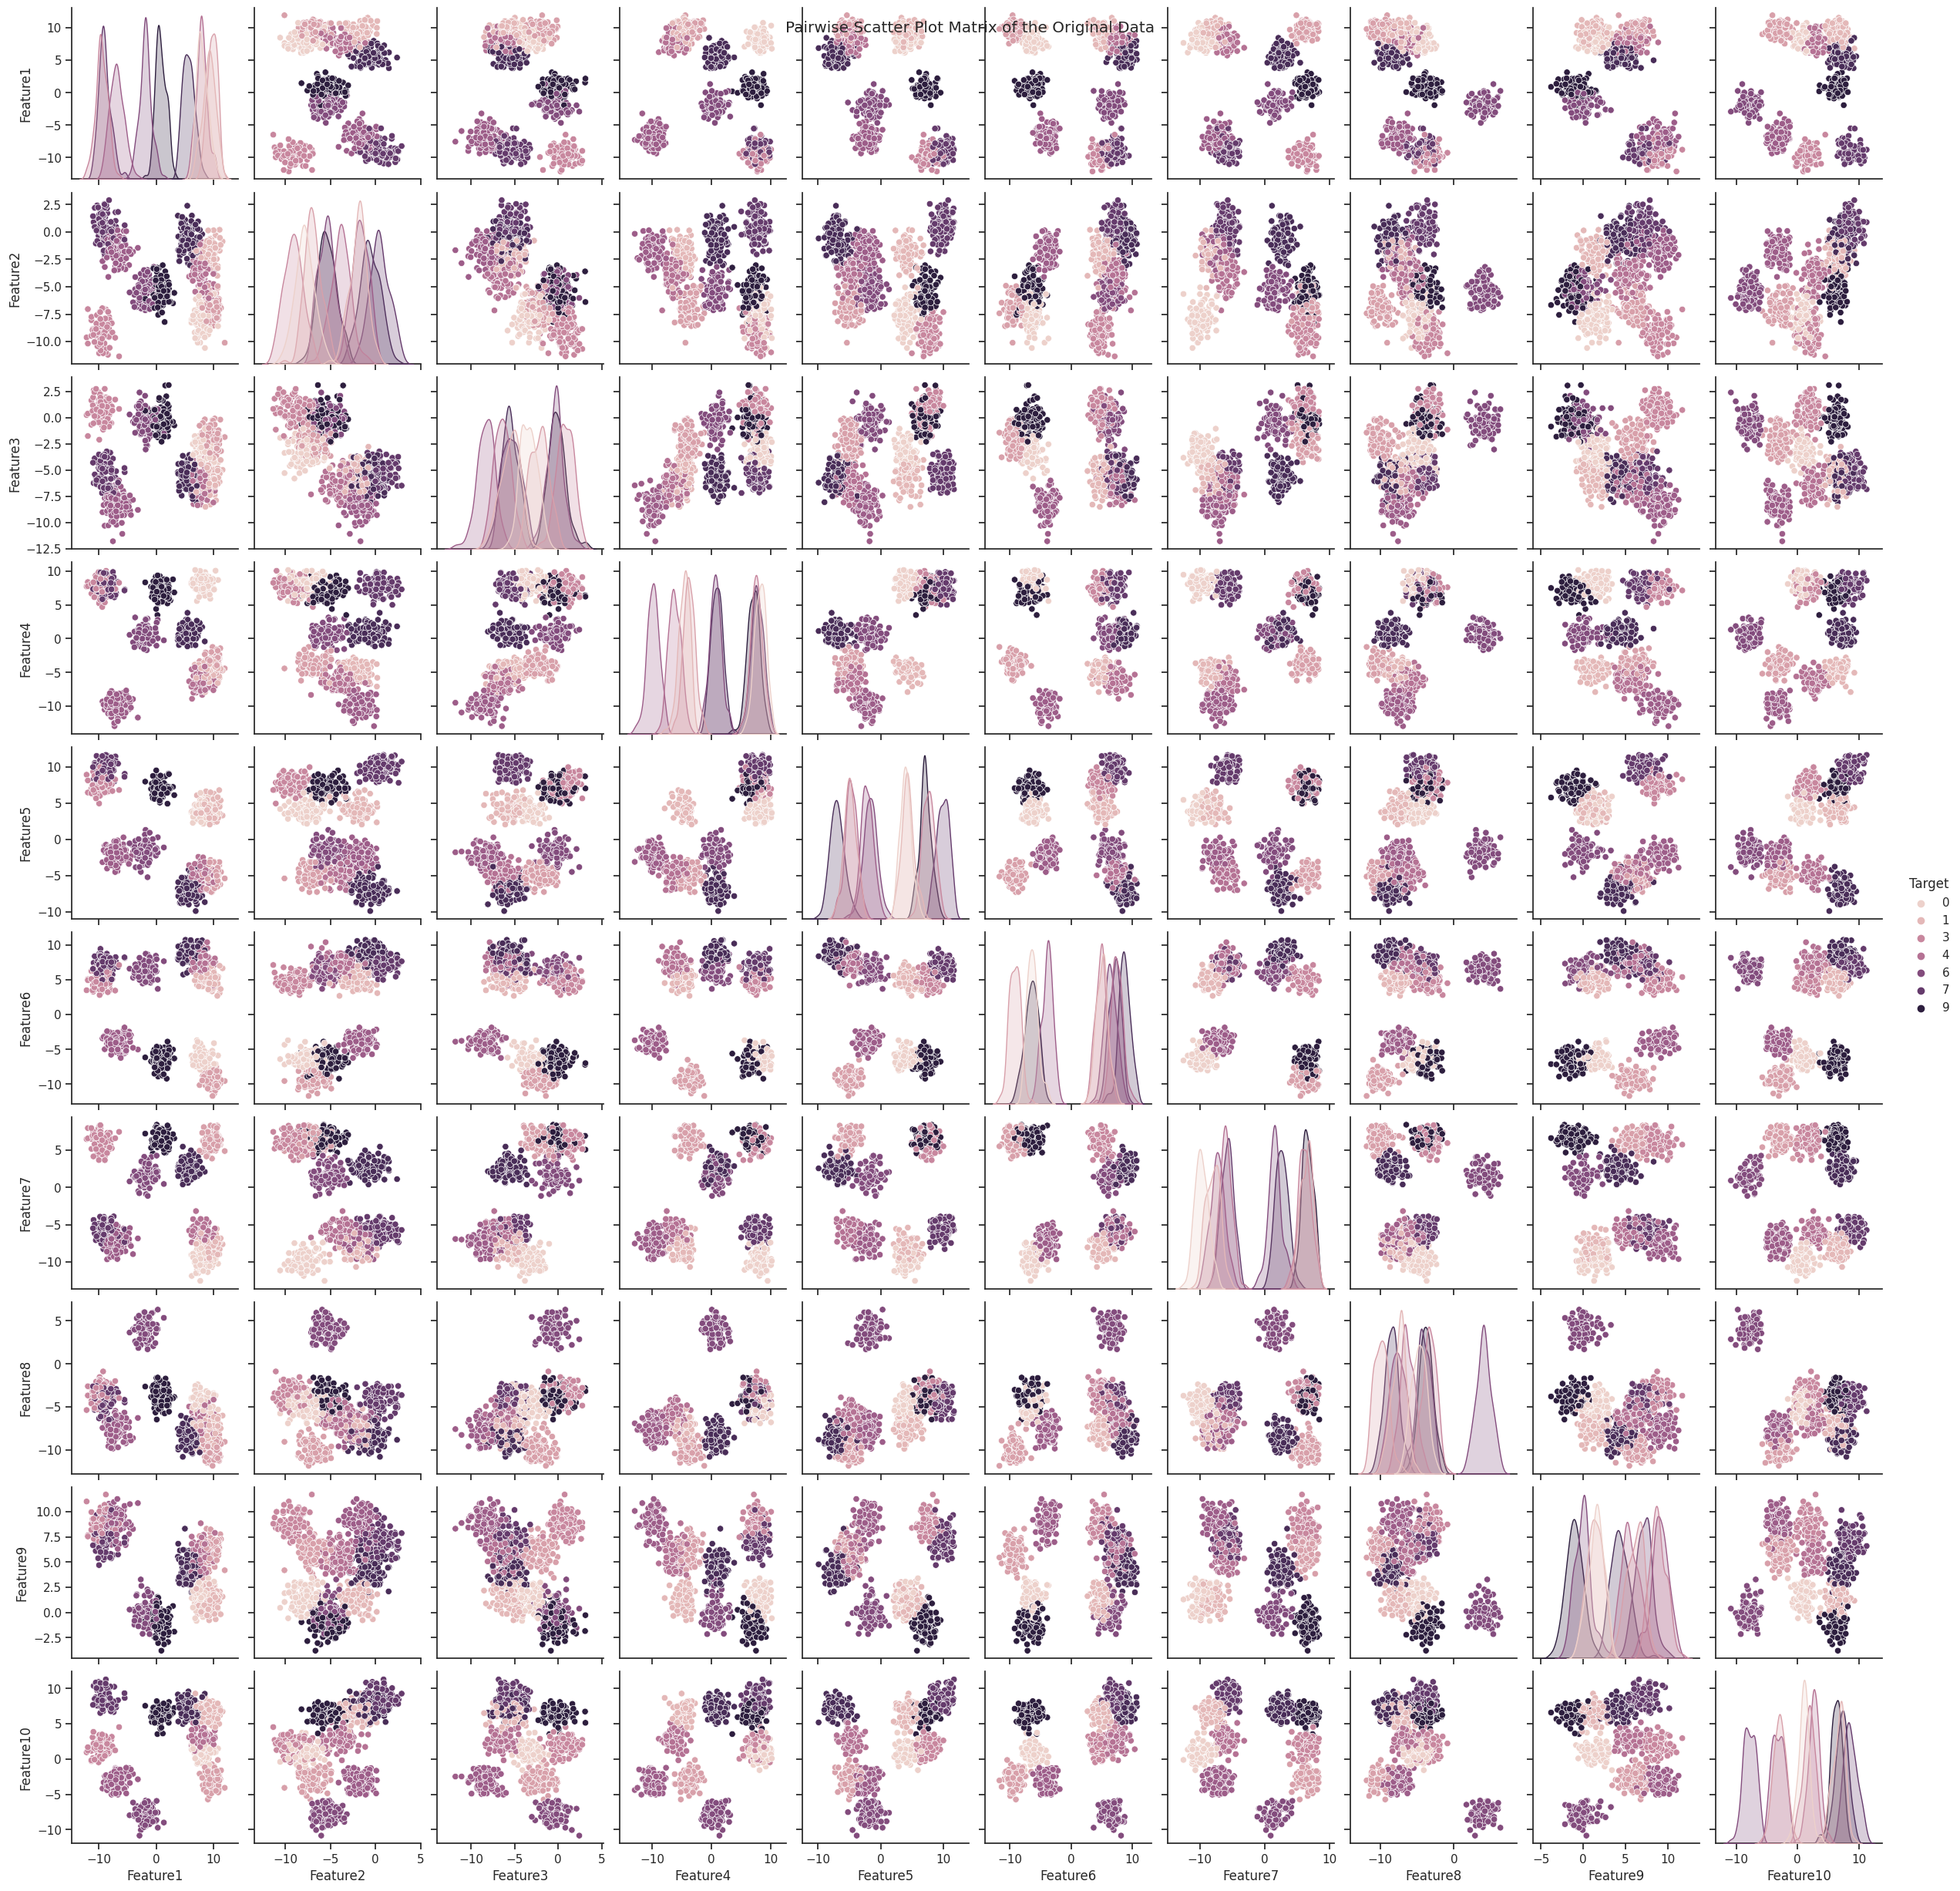

In [ ]:
#plot the data pairwise
#creat a dataframe
import pandas as pd
feature_names = [f'Feature{i}' for i in range(1, n_features+1)]
df= pd.DataFrame(X, columns= feature_names)
df['Target'] = y
sns.set(style= "ticks")
sns.pairplot(df, hue ="Target", markers = "o")
plt.suptitle("Pairwise Scatter Plot Matrix of the Original Data")
plt.show()

# **PCA with the Covariance Method**

**Steps:**

1. We must first center the values of each variable in the dataset on 0 by subtracting the mean from $X$.
2. Calculate the covariance matrix which is the same as correlation matrix from SVD, $Cov(X, X)$
3. Compute the eigen decomposition: eigenvalues and eigenvectors of the covariance matrice.
3. Sort the eigenvectors according to their eigenvalues of the covariance matrix.
4. Sort the eigenvectors according to their eigenvalues in decreasing order.
5. Choose first k eigenvectors and that will be the new k dimensions
6. Transform the original n-dimensional data points into k dimensions (projection with dot product)

In [130]:
class Newpca:
  def __init__(self, percentage):
    self.percentage= percentage
    self.n_components= None
    self.components= None
    self.mean = None
    self.scale = None
    self.cum_explained_variance = None
    self.explained_variance_ratio = None
    self.n_flops= None
    self.egv_time= None
  # Keep in mind this is an unsupervised method so we do not need labels
  def fit(self, X):
    start_time = time.time()
    # mean centerting
    X= X.copy()
    self.mean = np.mean(X, axis=0)
    self.scale= np.std(X, axis = 0)
    X_std= (X - self.mean) / self.scale

    # Calculate the covariance matrix
    cov = np.cov(X_std.T)
    # Calculate the eigenvectors and eigenvalues
    evalues, evectors = np.linalg.eig(cov)
    evectors= evectors.T


    # sort eigenvectors
    idxs= np.argsort(evalues)[::-1]
    evalues_sorted= evalues[idxs]
    evectors_sorted = evectors[idxs]
    # The alg selects enough components to explain enough of the variance

    total_var= np.sum(evalues)
    explained_variance_treshold= total_var *self.percentage
    cumulative_variance = 0
    self.n_components= 0
    for variance in evalues_sorted:
      cumulative_variance += variance
      self.n_components += 1
      if  cumulative_variance >= explained_variance_treshold:
            break

    self.components = evectors_sorted[:self.n_components,:]
    self.explained_variance_ratio = [i/np.sum(evalues) for i in evalues_sorted[:self.n_components]]
    self.cum_explained_variance =  np.cumsum(self.explained_variance_ratio)
    self.n_flops= np.sum([np.prod(matrix.shape) for matrix in [evectors]])
    self.egv_time = time.time() - start_time




    return self

    # user can set the desired number of components

  def transform(self, X):
    X= X.copy()
    X_std= (X- self.mean) / self.scale
    res=  np.dot(X, self.components.T)

    return res


In [131]:
pca= Newpca(0.95)
pca.fit(obs)
X_projected= pca.transform(obs)
print('Transformed data shape:', X_projected.shape)

Transformed data shape: (216, 167)


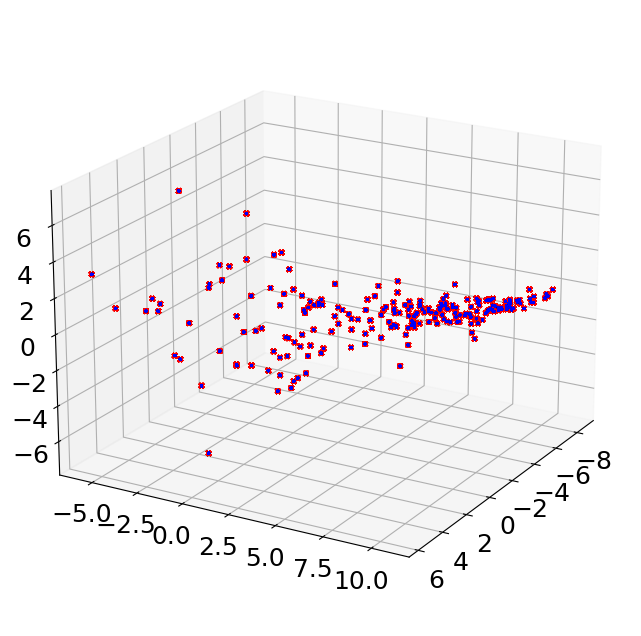

In [59]:
fig2= plt.figure()
ax= fig2.add_subplot(111, projection ='3d')
for j in range(obs.shape[0]):
  x= X_projected[:, 0 ]
  y= X_projected[:, 1]
  z= X_projected[:, 2]

  if grp[j] == 'Cancer':
    ax.scatter(x,y,z, marker= 'x', color= 'r', s= 10)
  else:
    ax.scatter(x,y,z, marker= 'o', color= 'b', s= 1)

ax.view_init(20, 30)
plt.show()

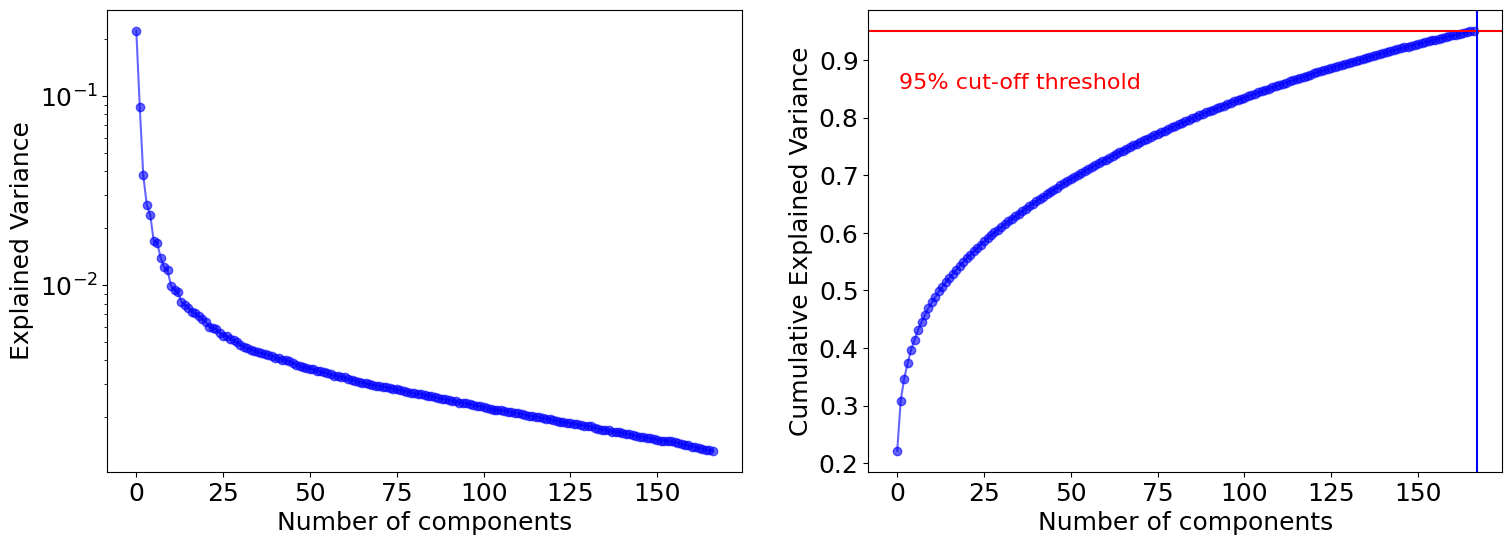

In [84]:
fig1= plt.figure(figsize= (18,6))
ax1 = fig1.add_subplot(121)
ax1.semilogy(pca.explained_variance_ratio, '-o', color= 'b', alpha= 0.6)
ax1.set_xlabel('Number of components')
ax1.set_ylabel('Explained Variance')
ax2 = fig1.add_subplot(122)
ax2.plot(pca.cum_explained_variance.round(4), '-o', color= 'b', alpha= 0.6)
# ax2.set_title(f'{pca.n_components} components, captures {pca.cum_explained_variance[pca.n_components-1].round(4)*100}% of total variation')
ax2.set_xlabel('Number of components')
ax2.set_ylabel('Cumulative Explained Variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.axvline(x= pca.n_components, color='b', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

plt.show()

# **PCA based on SVD**

In [126]:
class PCA_SVD:
    def __init__(self, percentage ):
        self.n_components = None
        self.components = None
        self.mean = None
        self.cum_sum_singular = None
        self.S= None
        self.n_flops = None
        self.svd_time = None
        self.percentage = percentage


    def fit(self, X):
        # mean centerting
        start_time= time.time()
        X= X.copy()
        self.mean = np.mean(X, axis=0)
        self.scale= np.std(X, axis = 0)
        X_std= (X - self.mean) / self.scale



        # Calculate economic SVD
        U, Sigma, Vt = np.linalg.svd(X_std, full_matrices=False)
        self.S= Sigma
        explained_variance = (self.S **2) / (X.shape[0]-1)
        total_var = explained_variance.sum()
        explained_variance_ratio = explained_variance / total_var
        self.cum_sum_singular = np.cumsum(explained_variance_ratio) / np.sum(explained_variance_ratio)

        explained_variance_treshold= total_var *self.percentage
        cumulative_variance = 0
        self.n_components= 0
        for variance in explained_variance:
          cumulative_variance += variance
          self.n_components += 1
          if  cumulative_variance >= explained_variance_treshold:
                break

        self.components = Vt.T[:, :self.n_components]
        self.n_flops= np.sum([np.prod(matrix.shape) for matrix in [U, Sigma, Vt]])
        self.svd_time = time.time() - start_time



        # self.cum_sum_singular = np.cumsum(Sigma)/ np.sum(Sigma)

    def transform(self, X):
        X= X.copy()
        X_std= (X- self.mean) / self.scale
        res= np.dot(X_std, self.components)

        return res

In [127]:
pca_svd = PCA_SVD(0.95)
pca_svd.fit(obs)
X_projected_svd = pca_svd.transform(obs)
print('Transformed data shape:', X_projected_svd.shape)

167
0.27993178367614746
Transformed data shape: (216, 167)


We want to plot the singular values. Fraction of the energy captured by the first $r$

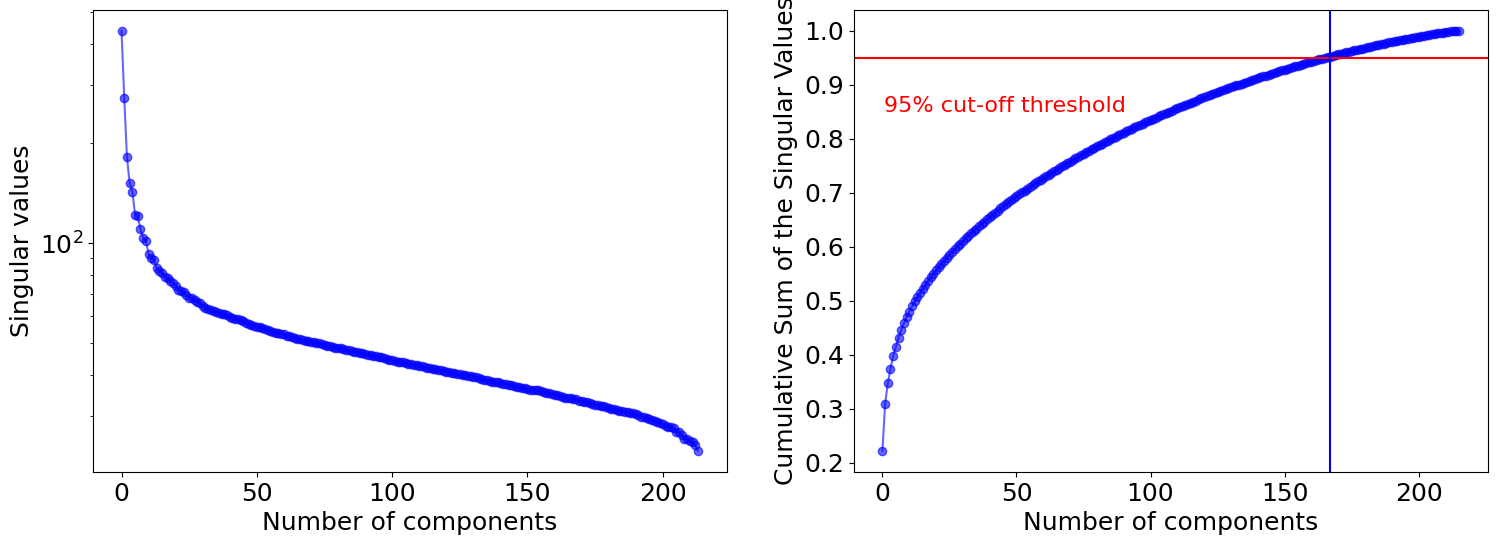

In [106]:
fig1= plt.figure(figsize= (18,6))
ax1 = fig1.add_subplot(121)
ax1.semilogy(pca_svd.S[:-2], '-o', color= 'b', alpha= 0.6)
ax1.set_xlabel('Number of components')
ax1.set_ylabel('Singular values')
ax2 = fig1.add_subplot(122)
ax2.plot(pca_svd.cum_sum_singular.round(4), '-o', color= 'b', alpha= 0.6)
# ax2.set_title('3 components, captures {}% of total variation'.format(pca_svd.cum_sum_singular[2].round(4)*100))
ax2.set_xlabel('Number of components')
ax2.set_ylabel('Cumulative Sum of the Singular Values')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.axvline(x=pca_svd.n_components, color='b', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

plt.show()

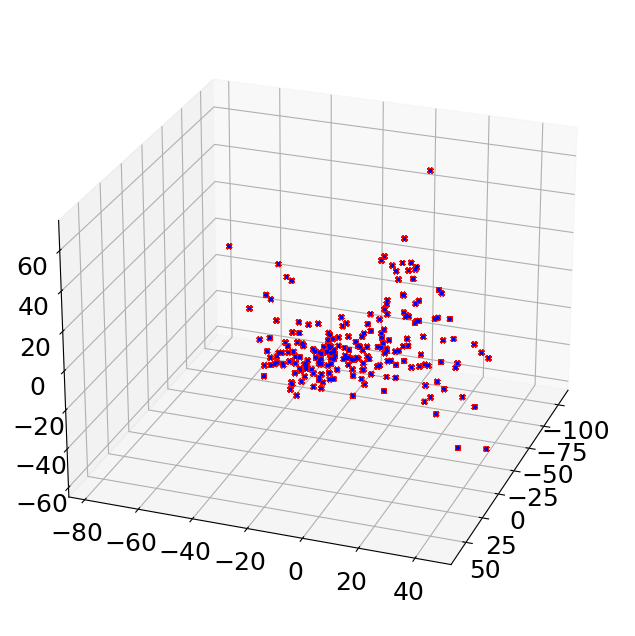

In [65]:
fig2= plt.figure()
ax= fig2.add_subplot(111, projection ='3d')
for j in range(obs.shape[0]):
  x= X_projected_svd[:, 0 ]
  y= X_projected_svd[:, 1]
  z= X_projected_svd[:, 2]

  if grp[j] == 'Cancer':
    ax.scatter(x,y,z, marker= 'x', color= 'r', s= 10)
  else:
    ax.scatter(x,y,z, marker= 'o', color= 'b', s= 1)

ax.view_init(25, 20)
plt.show()

Conclusion:
*   *Singular values plot:* you will notice first maybe three components are capturing a large fraction of energy comparing to other components. This observation underscores the significance of the first few components in capturing a significant proportion of the system's variation. What that means is that we can only keep these first few components and truncate a lot of the remaining singular values.
*   *Cumulative plot:* Just first 2 components capture about 64% of energy, and very rapidly we get up to 80%, 90%.

In [132]:
from prettytable import PrettyTable
table= PrettyTable()
table.field_names = ["Algorithm", " # PC", "Running Time (s)", "Number of Flops"]
table.add_row(["SVD", f"{pca_svd.n_components}", f"{pca_svd.svd_time}", f"{pca_svd.n_flops}"])
table.add_row(["EGV", f"{pca.n_components}", f"{pca.egv_time}", f"{pca.n_flops}"])

print(table)

+-----------+-------+---------------------+-----------------+
| Algorithm |  # PC |   Running Time (s)  | Number of Flops |
+-----------+-------+---------------------+-----------------+
|    SVD    |  167  | 0.27993178367614746 |      910872     |
|    EGV    |  167  |  62.04273080825806  |     16000000    |
+-----------+-------+---------------------+-----------------+


# **PCA with Scikit-Learn**

In [99]:
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(obs)

from sklearn.decomposition import PCA
pca = PCA(0.95).fit(X_std)

# print('Components:\n', pca.components_)
# print('Explained variance ratio:\n', pca.explained_variance_ratio_)
cum_explained_variance = np.cumsum(pca.explained_variance_ratio_)
# print('Cumulative explained variance:\n', cum_explained_variance)
X_pca = pca.transform(X_std) # Apply dimensionality reduction to X.
print('Transformed data shape:', X_pca.shape)

# plt.scatter(X_pca[:, 0], X_pca[:, 1], c = y)
# plt.xlabel('PC1'); plt.xticks([])
# plt.ylabel('PC2'); plt.yticks([])
# plt.title('2 components, captures {}% of total variation'.format(cum_explained_variance[1].round(4)*100))
# plt.show()

Transformed data shape: (216, 167)


Explained variance

# **PCA Via Minimal Reconstruction Error**

In [ ]:
class PCA_SVD:
    def __init__(self, percentage ):
        self.n_components = None
        self.components = None
        self.mean = None
        self.cum_sum_singular = None
        self.S= None
        self.n_flops = None
        self.svd_time = None
        self.percentage = percentage


    def fit(self, X):
        # mean centerting
        start_time= time.time()
        X= X.copy()
        self.mean = np.mean(X, axis=0)
        self.scale= np.std(X, axis = 0)
        X_std= (X - self.mean) / self.scale



        # Calculate economic SVD
        U, Sigma, Vt = np.linalg.svd(X_std, full_matrices=False)
        self.S= Sigma
        explained_variance = (self.S **2) / (X.shape[0]-1)
        total_var = explained_variance.sum()
        explained_variance_ratio = explained_variance / total_var
        self.cum_sum_singular = np.cumsum(explained_variance_ratio) / np.sum(explained_variance_ratio)

        explained_variance_treshold= total_var *self.percentage
        cumulative_variance = 0
        self.n_components= 0
        for variance in explained_variance:
          cumulative_variance += variance
          self.n_components += 1
          if  cumulative_variance >= explained_variance_treshold:
                break
        print(self.n_components)
        self.components = Vt.T[:, :self.n_components]
        self.n_flops= np.sum([np.prod(matrix.shape) for matrix in [U, Sigma, Vt]])
        self.svd_time = time.time() - start_time
        print(self.svd_time)


        # self.cum_sum_singular = np.cumsum(Sigma)/ np.sum(Sigma)

    def transform(self, X):
        X= X.copy()
        X_std= (X- self.mean) / self.scale
        res= np.dot(X_std, self.components)

        return res

In [13]:
class Reconst:
  def __init__(self, percentage):
    self.percentage= percentage
    self.n_components= None
    self.components= None
    self.mean = None
    self.scale = None
    self.cum_explained_variance = None
    self.explained_variance_ratio = None
    self.n_flops= None
    self.egv_time= None
  # Keep in mind this is an unsupervised method so we do not need labels
  def fit(self, X):
    start_time = time.time()
    # mean centerting
    X= X.copy()
    self.mean = np.mean(X, axis=0)
    self.scale= np.std(X, axis = 0)
    X_std= (X - self.mean) / self.scale

    # Calculate the covariance matrix
    cov = np.cov(X_std.T)
    # Calculate the eigenvectors and eigenvalues
    evalues, evectors = np.linalg.eig(cov)
    evectors= evectors.T


    # sort eigenvectors
    idxs= np.argsort(evalues)[::-1]
    evalues_sorted= evalues[idxs]
    evectors_sorted = evectors[idxs]
    # The alg selects enough components to explain enough of the variance

    total_var= np.sum(evalues)
    explained_variance_treshold= total_var *self.percentage
    cumulative_variance = 0
    self.n_components= 0
    for variance in evalues_sorted:
      cumulative_variance += variance
      self.n_components += 1
      if  cumulative_variance >= explained_variance_treshold:
            break

    self.components = evectors_sorted[:self.n_components,:]
    self.explained_variance_ratio = [i/np.sum(evalues) for i in evalues_sorted[:self.n_components]]
    self.cum_explained_variance =  np.cumsum(self.explained_variance_ratio)
    self.n_flops= np.sum([np.prod(matrix.shape) for matrix in [evectors]])
    self.egv_time = time.time() - start_time




    return self

    # user can set the desired number of components

  def transform(self, X):
    X= X.copy()
    X_std= (X- self.mean) / self.scale
    Z =  np.dot(X_std, self.components.T)
    rec = np.dot(Z, self.components)
    rec_err= np.linalg.norm(X_std - rec, 'fro')


    return rec_err


In [14]:
pca_rec = Reconst(0.95)
X_rec= pca_rec.fit(obs)
X_rec_fit= pca_rec.transform(obs)

print("\nReconstruction Error:", X_rec_fit)


Reconstruction Error: 206.29353988529894


In [ ]:
# # PCA based on SVD
# class PCA_SVD:
#   def __init__(self, n_components):
#     self.n_components= n_components
#     self.mean =  None
#     self.stand= None
#     self.U = None
#     self.Sigma = None
#     self.Vt= None


#   def fit(self,x):
#     self.mean = sum(x) / len(x)
#     self.stand= (sum((i- self.mean) **2 for i in x)/ len(x)) ** 0.5
#     x_centered = x - self.mean / self.stand

#     U, sigma, Vt = self.mySVD(x_centered)

#     self.U= U[:, :self.n_components]
#     self.sigma = np.diag(sigma[:self.n_components])
#     self.Vt = Vt[:self.n_components, :]

#     self.components = U[:self.n_components]
#     return self.components


#   def transform(self, x):
#     x_centered = x - self.mean / self.stand
#     return np.dot(x_centered, self.components.T)


#   def mySVD(self, x):
#     U, sigma, Vt= self.bidiagnolize(x)
#     U, sigma, Vt = self.qr_alg(U, sigma, Vt)
#     return U, sigma, Vt


#   def set_low_level_zero(self,x):
#     low_values_indices = abs(x) < 9e-15
#     x[low_values_indices] = 0
#     return x

#   def bidiagnolize(self, x):
#     n, m = x.shape
#     U= np.eye(n)
#     Vt= np.eye(m)
#     sigma = np.zeros((n,m))

#     for k in range(min(n,m)):
#       x_new= x[k:, k:]
#       alpha = np.linalg.norm(x_new[:,0])
#       beta= np.linalg.norm(x_new[0,:])
#       u = x_new[:,0].reshape(-1,1) / alpha
#       v = x_new[0,:].reshape(1,-1) / beta

#       U[k:, k:] -= 2* np.outer(u,u)
#       Vt[k:, k:] -= 2* np.outer(v,v)

#       sigma[k,k] = alpha

#       if k< min(n, m) -1 :
#         x[k: , k+1:] -=  2* np.outer(u, np.dot(v, x[k:, k+1:]))

#       return U, sigma, Vt

#   def qr_alg(self, U, sigma, Vt, tol= 1e-10, max_iter= 100):
#     n, m = sigma.shape

#     for _ in range(max_iter):
#       Q, R = np.linalg.qr(np.dot(Vt.T, U))
#       U= np.dot(U, Q)
#       Vt = np.dot(R, Vt)

#       Q, R = np.linalg.qr(np.dot(Vt.T, U))
#       sigma= np.dot(R, sigma)
#       sigma = np.dot(sigma, Q.T)

#       error = np.sum(np.abs(np.dot(sigma, Q.T)- np.dot(Vt.T, U)))
#       if error < tol:
#         break

#       return U, sigma, Vt

# svd_model = PCA_SVD(2)
# svd_model.fit(X)
# X_projected_svd = svd_model.transform(X)
# print(f"{X.shape}, {X_projected_svd.shape}")

In [ ]:
  # def Householder(self, x,i):
  #   alpha = -np.sign(x[i]) *np.linalg.norm(x)
  #   e= np.zeros(len(x)) ; e[i] = 1.0

  #   v= (x- alpha *e)
  #   w= v / np.linalg.norm(v)
  #   p = np.eye(len(x)) - 2* np.outer(w, w.T)
  #   return p

  # def Golub_kahan(self, x):
  #   col = x.shape[1]
  #   row = x.shape[0]

  #   J = x.copy()

  #   for i in range(col-2):
  #     h= np.zeros(len(J[:,i]))
  #     h[i:] =  J[i:,i]
  #     p = self.Householder(h, i)
  #     J= self.set_low_level_zero(p @ J)
  #   return J

In [ ]:
# imort the dataset and split it to test and train
from sklearn.datasets import make_blobs
n_features = 10
X, y = make_blobs(centers=10, n_samples=1000, n_features=n_features)


In [ ]:
# from sklearn.datasets import load_iris
# data = load_iris()
# X, y =data.data, data.target

In [ ]:
pca= PCA(2)
pca.fit(X)
X_projected= pca.transform(X)
print(f" Dimensions of the original dataset before PCA: {X.shape[1]}\n Dimensions after PCA: {X_projected.shape[1]}")

 Dimensions of the original dataset before PCA: 10
 Dimensions after PCA: 2


<ipython-input-37-5cf66740df15>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(x1,x2, c=y, edgecolor ='none', alpha= 0.8, cmap = plt.cm.get_cmap("viridis", n_features))


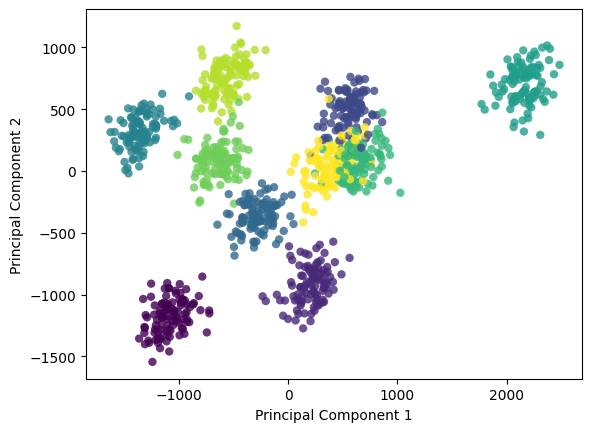

In [ ]:
# plotting the data
x1= X_projected[:,0]
x2= X_projected[:,1]
plt.scatter(x1,x2, c=y, edgecolor ='none', alpha= 0.8, cmap = plt.cm.get_cmap("viridis", n_features))
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

**PCA based on SVD**

Provides us with data driven heirarchical coordinate system. Coordinate system based on the direction which captures the maximum variance of the data. Here the data matrice is $X$, which is a $n*m$ matrice where $n$ is the number of samples, and $m$ is the number of features.
Steps:
1. Compute the mean row (result is a row vector):

$\bar{x} = \frac{1}{n} \sum_{j=1}^{n}X_j$

then by taking a column vector of ones and multiplying it by $\bar{x}$ vector, we can compute the $\bar{X}$.  

2. Subtract the mean from my dataset. This is the mean centered data.
$B = X- \bar{X} $

3. Compute the covariance matrix of the mean centered data. (This is as same as correlation matrix from SVD)
$C= B^{T} B$

4. Now we should find the leading eigens of $C$.


**SVD**

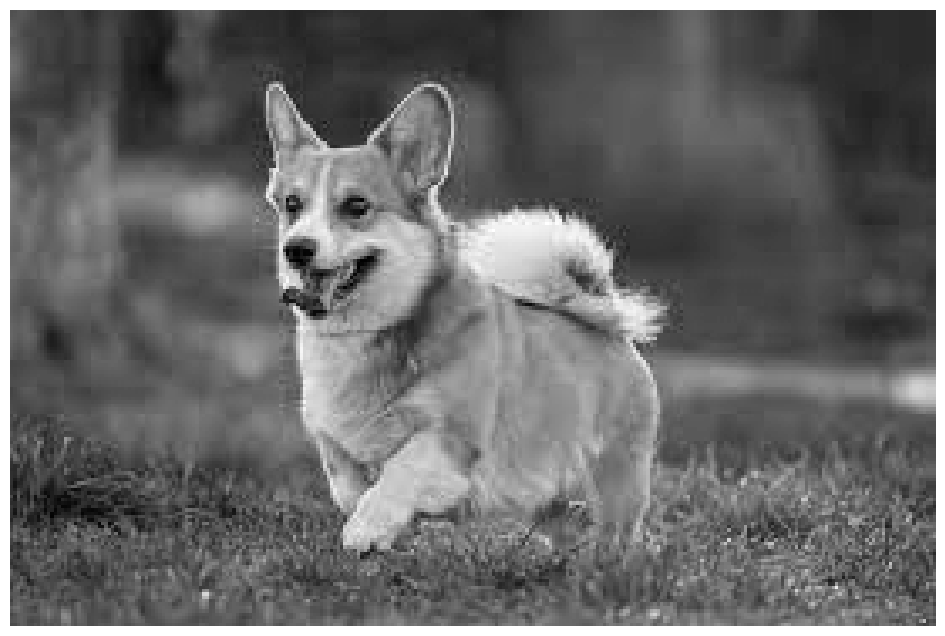

In [ ]:
from matplotlib.image import imread
import matplotlib.pyplot as plt
import numpy as np
import os
plt.rcParams['figure.figsize'] = [16,8]
A= imread('download.jpg')
X= np.mean(A,-1);
img= plt.imshow(X)
img.set_cmap('gray')
plt.axis('off')
plt.show()


# New Section

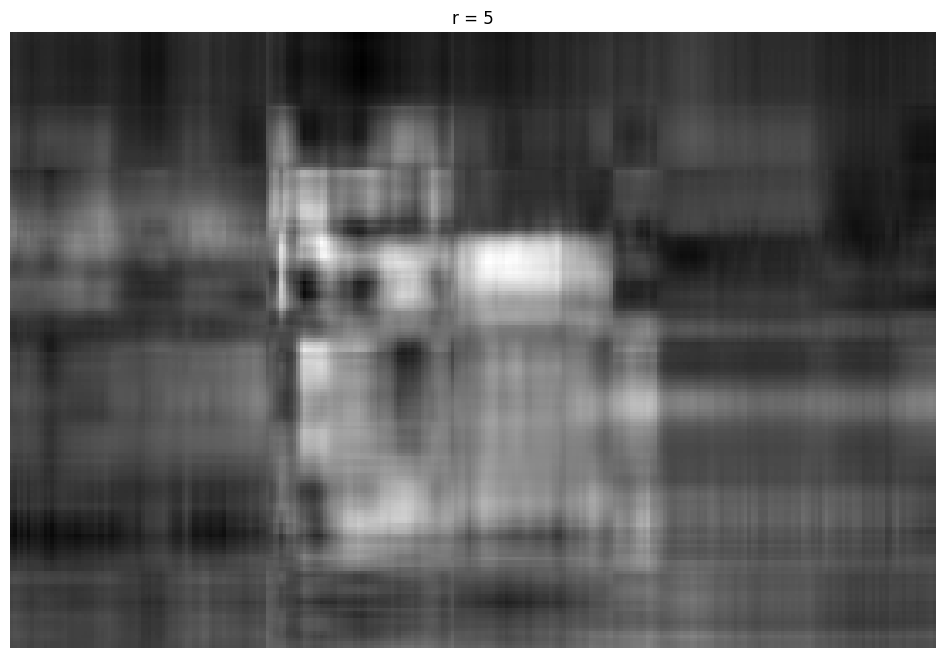

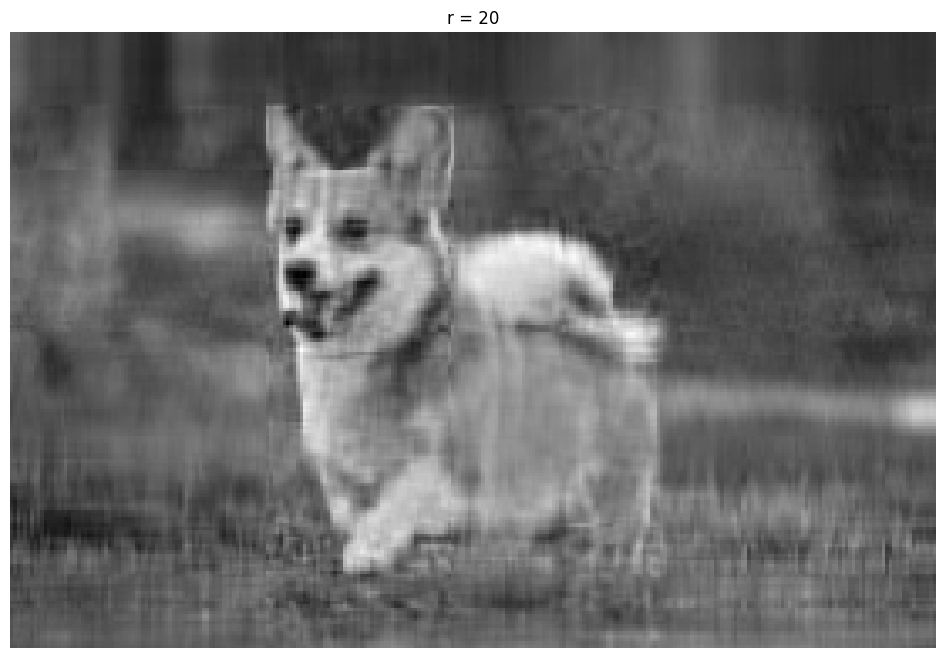

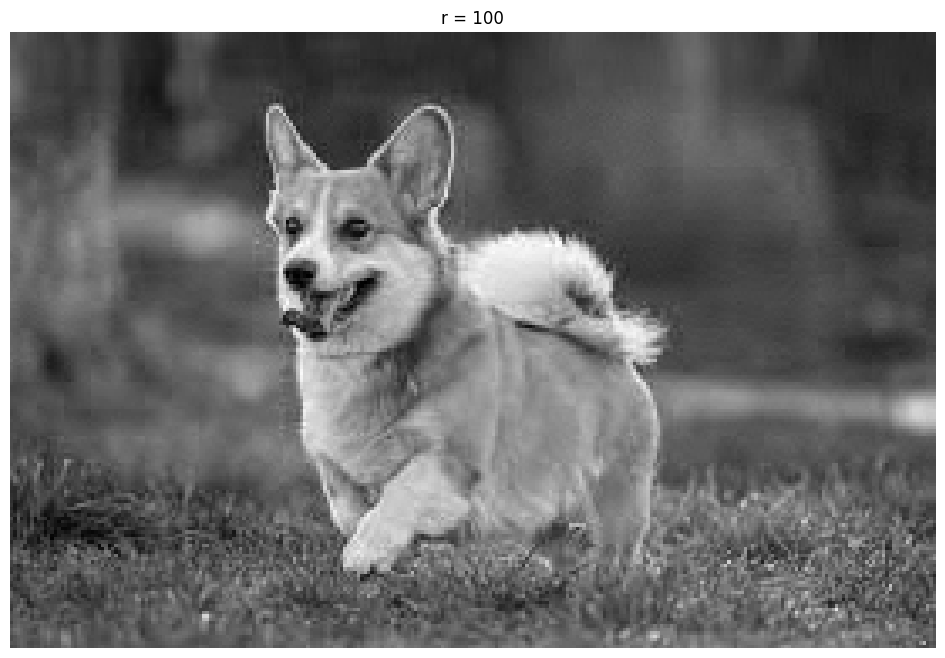

In [ ]:
U, S, VT= np.linalg.svd(X, full_matrices= False)
S= np.diag(S)
#low rank approximation
j= 0
for r in (5,20,100):
    # 100 rank is 8 times compression
    Xapprox = U[:,:r] @ S[0:r, :r] @ VT[:r, :]
    plt.figure(j+1)
    j +=1
    img= plt.imshow(Xapprox)
    img.set_cmap('gray')
    plt.axis('off')
    plt.title('r = ' +str(r))
    plt.show()

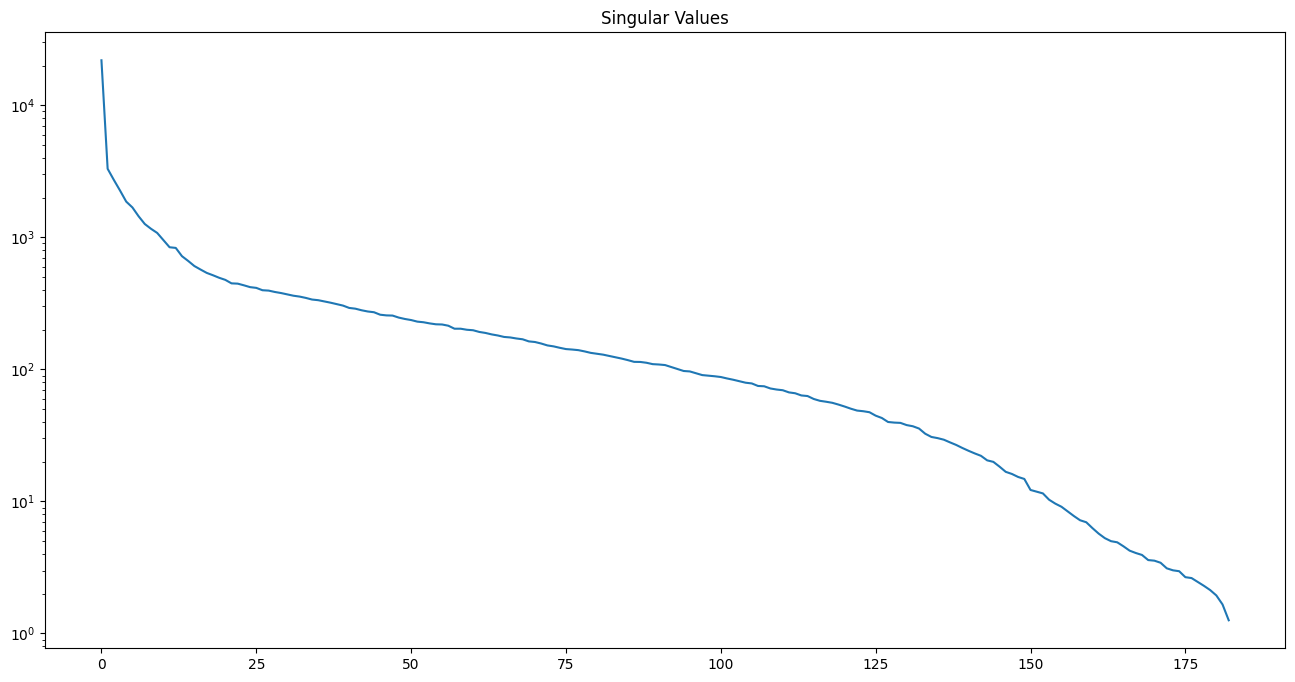

In [ ]:
#plotting the singular values
plt.figure(1)
plt.semilogy(np.diag(S))
plt.title('Singular Values')
plt.show()


There is a lot of energy in the first few modes(ten or twenty modes), and that is capturing a large fraction of energy. So th first singular values are much larger. So, we can keep only the first few and throw away the rest of the remaining singular values.



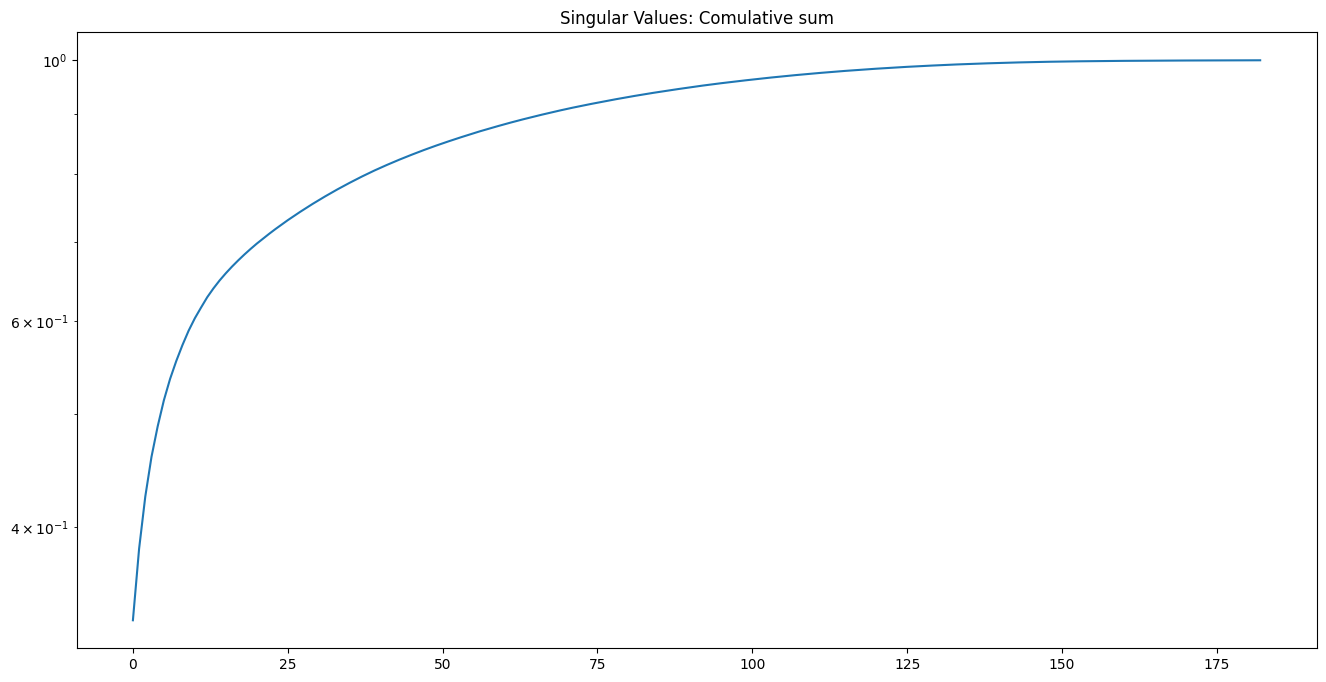

In [ ]:
plt.figure(1)
plt.semilogy(np.cumsum(np.diag(S))/ np.sum(np.diag(S)))
plt.title('Singular Values: Comulative sum')
plt.show()

Very rapidly we capture the 80% of the energy only with first ranks.

We gonna creat a dataset that is Gussian distributed data with some direction of high variance and some direction of low variance. This dataset is the large Gussian cloud of data points that is going to be moved away from the origin and streched out in some directions and compressed and rotated. It is not zero mean and it has directional principal variations.


(2, 10000)


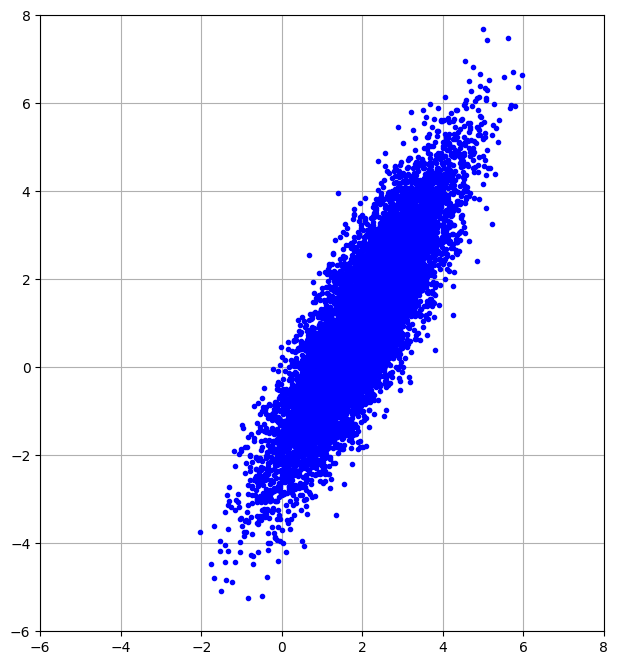

In [ ]:
#creating the data
plt.rcParams['figure.figsize'] = [16,8]
xC = np.array([2,1]) #center of the data
sig = np.array([2, 0.5]) #ptrinicipal axes
theta = np.pi/3  #rotate the cloud by pi/3
R = np.array ([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]]) #rotation matrix
nPoints = 10000
X= R @ np.diag(sig) @ np.random.randn(2, nPoints) + np.diag(xC) @ np.ones((2, nPoints))

fig= plt.figure()
ax1 = fig.add_subplot(121)
ax1.plot(X[0, :], X[1, :], '.', color= 'blue')
ax1.grid()
plt.xlim(-6,8)
plt.ylim(-6,8)
print(X.shape)

(2, 2) (2,)


TypeError: ignored

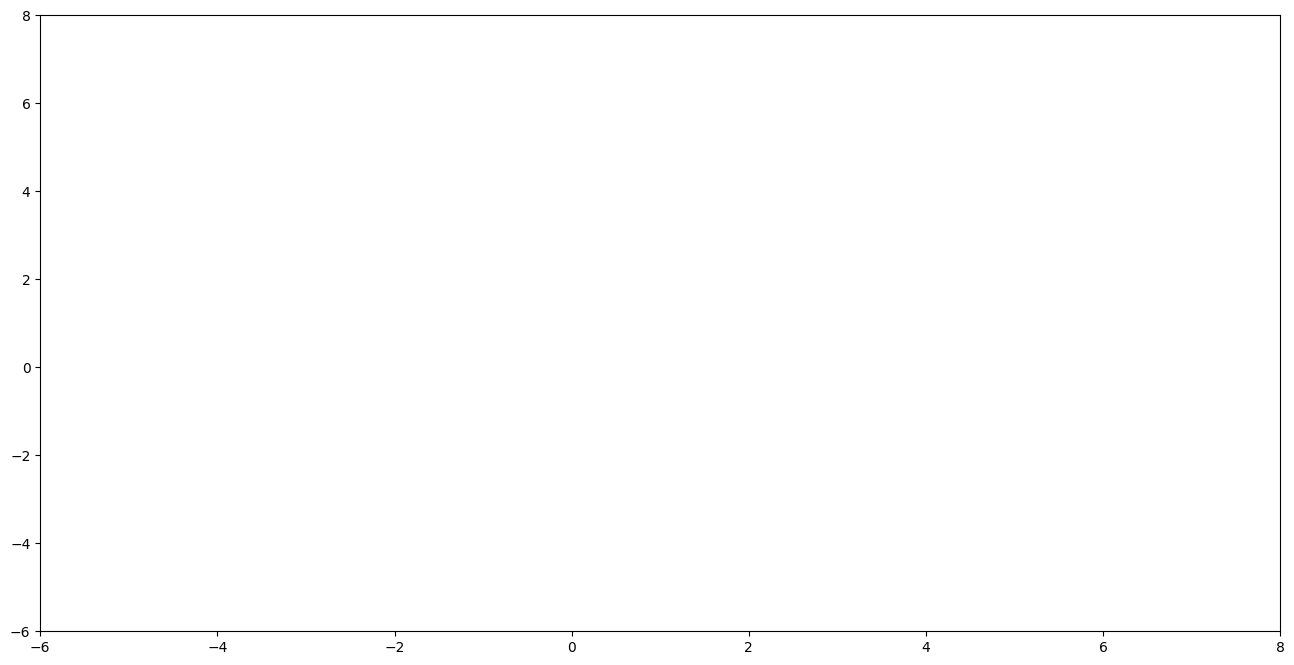

In [ ]:
X_mean = np.mean(X, axis= 1)
B = X - np.tile(X_mean, (nPoints,1)).T
# Find the principal components
U, S, VT  = np.linalg.svd(B/ np.sqrt(nPoints))
ax2= fig.add_subplot(122)
ax2.plot(X[0,:], X[1,:], '.', color ='red')
ax2.grid()
plt.xlim((-6,8))
plt.ylim((-6, 8))



theta = 2 * np.pi * np.arange(0,1,0.01)
Xstd = U @ np.diag(S) @ np.array([np.cos(theta),np.sin(theta)])
ax2.plot(X_mean[0] + Xstd[0,:], X_mean[1] + Xstd[1,:],'-',color= 'r')
ax2.plot(X_mean[0] + 2*Xstd[0,:], X_mean[1] + 2*Xstd[1,:],'-', color='r')
ax2.plot(X_mean[0] + 3*Xstd[0,:], X_mean[1] + 3*Xstd[1,:],'-',
color='r')

plt.show()